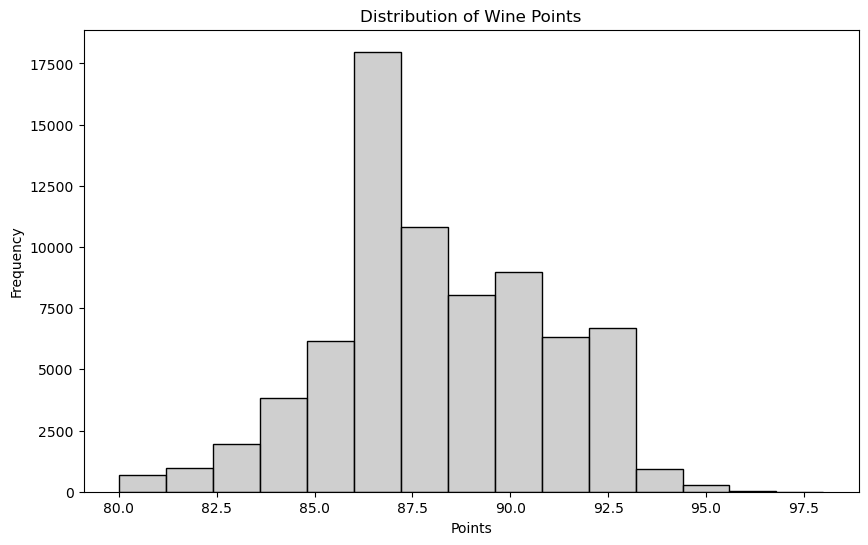

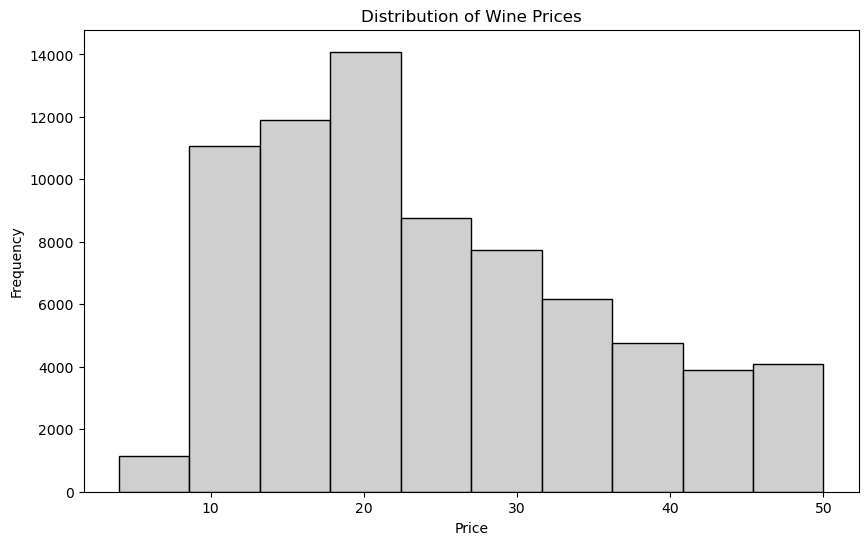

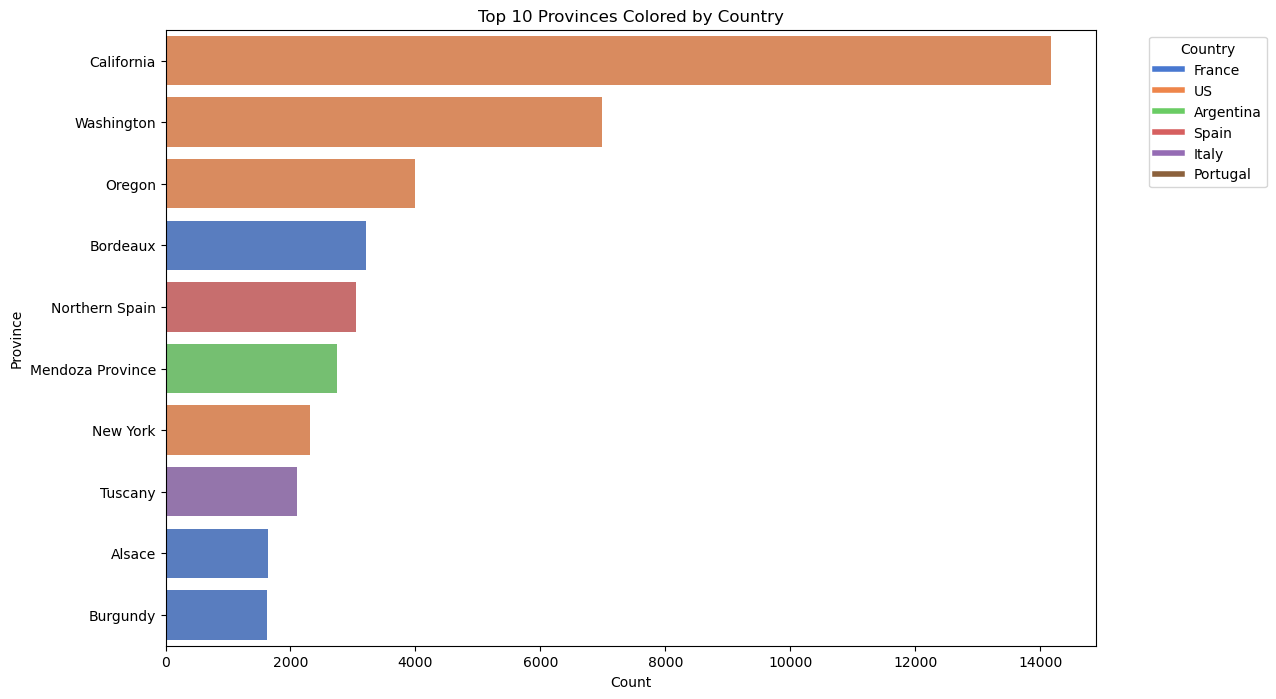

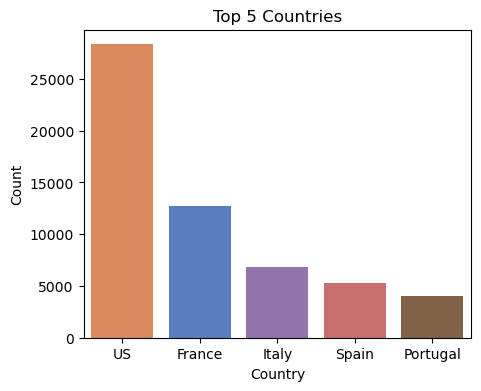

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

# Load the data
file_path = '/Users/annelise/Documents/GitHub/Wine_tasting_KG/data_kaggle/'
wine_data = pd.read_csv(file_path + 'cleaned_wine_data.csv')

# Filter out wines with a price > 50
wine_data_low = wine_data.loc[wine_data.price <= 50]
wine_data_low.to_csv(file_path + 'cleaned_wine_data_price_max=50.csv', index=False)

# Summary statistics
summary_stats = wine_data_low.describe(include='all')
#print("data summary", summary_stats)

# Distribution of wine points
plt.figure(figsize=(10, 6))
sns.histplot(wine_data_low['points'], bins=15, color="silver")
plt.title('Distribution of Wine Points')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.show()

# Distribution of wine prices
plt.figure(figsize=(10, 6))
sns.histplot(wine_data_low['price'], bins=10, color="silver")
plt.title('Distribution of Wine Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Top 10 provinces colored by Country 
top_provinces = wine_data_low['province'].value_counts().head(10).index
filtered_data = wine_data_low[wine_data_low['province'].isin(top_provinces)]
province_country_map = filtered_data.groupby('province')['country'].first().to_dict()
province_counts = wine_data_low['province'].value_counts().loc[top_provinces]

# Set a color palette for Countries for both plots
top_countries_in_provinces = list(province_country_map.values())
top_countries = wine_data_low['country'].value_counts().head(5).index
unique_countries = pd.unique(top_countries_in_provinces + list(top_countries))
color_palette = sns.color_palette("muted", len(unique_countries))
country_color_map = dict(zip(unique_countries, color_palette))

# Apply the color mapping to the provinces
province_colors = [country_color_map[province_country_map[province]] for province in province_counts.index]
plt.figure(figsize=(12, 8))
sns.barplot(y=province_counts.index, x=province_counts.values, palette=province_colors)
plt.title('Top 10 Provinces Colored by Country')
plt.xlabel('Count')
plt.ylabel('Province')

# Create a custom legend
handles = [plt.Line2D([0], [0], color=country_color_map[country], lw=4) for country in unique_countries]
plt.legend(handles, unique_countries, title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plotting the top 5 countries with matching colors
plt.figure(figsize=(5, 4))
sns.barplot(x=top_countries, y=wine_data_low['country'].value_counts().loc[top_countries], 
            palette=[country_color_map[country] for country in top_countries])
plt.title('Top 5 Countries')
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()


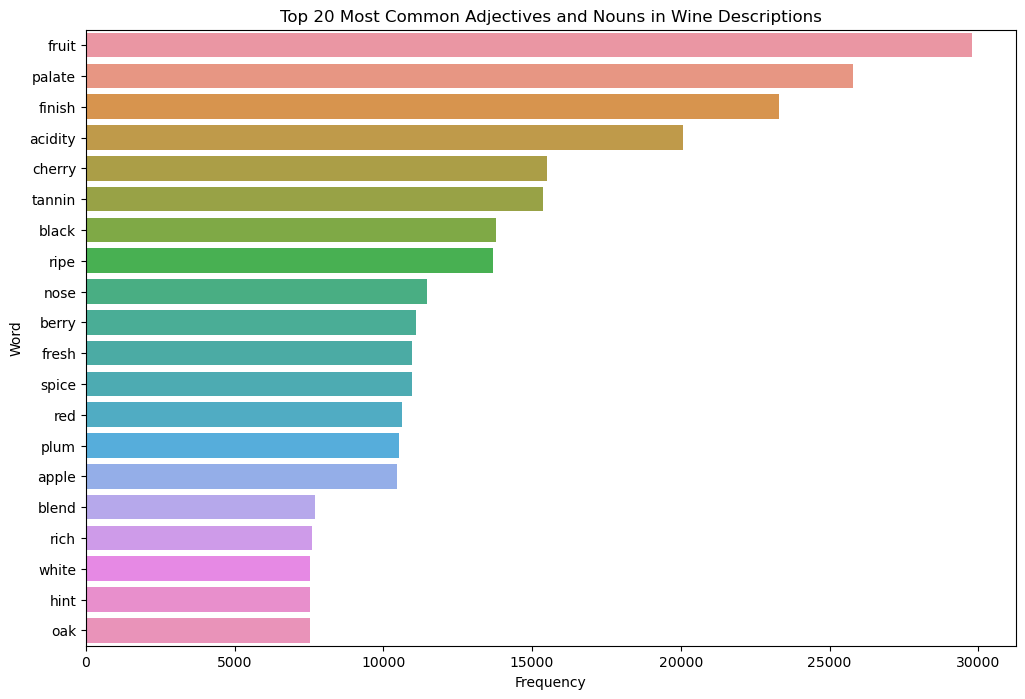

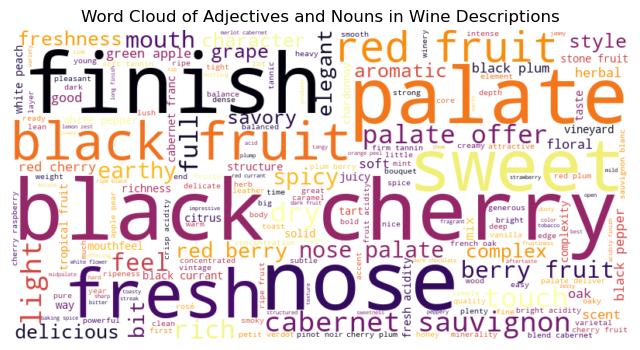

In [13]:
from collections import Counter
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# List of multi-word expressions (MWEs) to keep together
multi_word_expressions = [
    'red fruit', 'black fruit', 'tropical fruit', 'stone fruit', 'citrus fruit', 
    'green apple'
]

# List of specific words to always keep
words_to_keep = [
    'lime', 'lemon', 'orange', 'grapefruit', 'apple', 'berry', 'peach', 'plum', 
    'melon', 'nectarine', 'pineapple', 'mango', 'papaya', 'blackberry', 'raspberry', 
    'cherry', 'blueberry', 'strawberry'
]

# Helper function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Function to detect and merge MWEs before processing
def detect_and_merge_mwes(description):
    for mwe in multi_word_expressions:
        if mwe in description:
            description = description.replace(mwe, mwe.replace(" ", "_"))  # Temporarily replace space with underscore
    return description

# Function to process descriptions
def process_description(description):
    # Handle MWEs first
    description = detect_and_merge_mwes(description.lower())
    
    # Tokenize and remove stopwords
    words = word_tokenize(description)
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word.isalpha() or "_" in word]  # Allow MWEs to pass through
    
    # POS tagging
    pos_tags = pos_tag(filtered_words)
    
    processed_words = []
    for word, pos in pos_tags:
        wordnet_pos = get_wordnet_pos(pos)
        
        # Handle MWEs (keep them together) and lemmatize nouns
        if "_" in word:
            processed_words.append(word)  # Keep underscore to avoid splitting
        else:
            if wordnet_pos == wordnet.NOUN:
                word = lemmatizer.lemmatize(word, pos=wordnet_pos)
            # Ensure words to keep are added even if they are not adjectives/nouns
            if (pos in ['JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS']) or word in words_to_keep:
                processed_words.append(word)
    
    # Remove specific unwanted nouns but keep MWEs and specific words
    exclude_nouns = {'wine', 'aroma', 'flavor', 'note', 'drink'}
    processed_words = [word for word in processed_words if word not in exclude_nouns or word in words_to_keep or "_" in word]
    
    # Convert underscores back to spaces for the final output
    processed_words = [word.replace("_", " ") for word in processed_words]
    
    return ' '.join(processed_words)

# Apply processing to each description and create a new column
wine_data_low.loc[:, 'processed_description'] = wine_data_low['description'].dropna().apply(process_description)

# Extract all processed words for frequency counting
all_processed_words = ' '.join(wine_data_low['processed_description']).split()

# Count frequencies of the unique adjectives and nouns
word_freq = Counter(all_processed_words).most_common(20)

# Display the top 20 most common adjectives and nouns
word_freq_df = pd.DataFrame(word_freq, columns=['Word', 'Frequency'])

# Plotting the top 20 most common adjectives and nouns
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Word', data=word_freq_df)
plt.title('Top 20 Most Common Adjectives and Nouns in Wine Descriptions')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

# Generate a word cloud for a more visual representation
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='inferno').generate(' '.join(all_processed_words))
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Adjectives and Nouns in Wine Descriptions')
plt.show()

# Save csv file 
wine_data_low.to_csv(file_path + 'cleaned_wine_data_price_max=50_desc=cleaned.csv', index=False)

In [14]:
# Initialize a dictionary to store MWE frequencies
mwe_frequencies = {mwe: 0 for mwe in multi_word_expressions}

# Count MWEs in the processed descriptions
for description in wine_data_low['processed_description']:
    for mwe in multi_word_expressions:
        mwe_with_underscore = mwe.replace(" ", "_")
        count = description.count(mwe_with_underscore.replace("_", " "))
        mwe_frequencies[mwe] += count

# Display the frequencies of each MWE
mwe_frequencies_df = pd.DataFrame(list(mwe_frequencies.items()), columns=['MWE', 'Frequency'])
mwe_frequencies_df.sort_values(by='Frequency', ascending=False, inplace=True)

# Display the DataFrame
print(mwe_frequencies_df)

              MWE  Frequency
1     black fruit       2708
0       red fruit       2675
5     green apple       1551
2  tropical fruit       1296
3     stone fruit       1234
4    citrus fruit        513


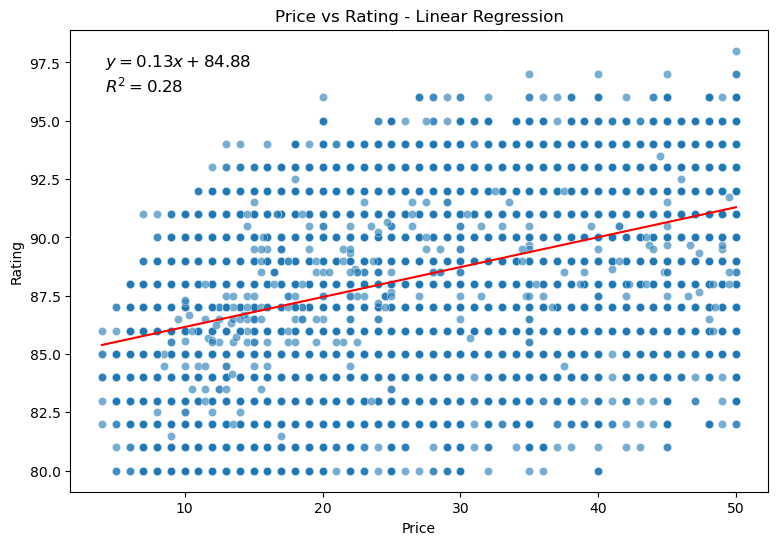

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Scatterplot with linear regression line and stats
plt.figure(figsize=(9, 6))

# Scatterplot
sns.scatterplot(data=wine_data_low, x='price', y='points', alpha=0.6)

# Fit a linear regression model
X = wine_data_low['price'].values.reshape(-1, 1)  # Reshape for sklearn
y = wine_data_low['points'].values
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

# Plot the regression line
sns.lineplot(x=wine_data_low['price'], y=y_pred, color='red')

# Compute R^2 and regression coefficients
slope = model.coef_[0]
intercept = model.intercept_
r2 = r2_score(y, y_pred)

# Annotate the plot with the regression equation and R^2 value
plt.text(0.05, 0.95, f'$y = {slope:.2f}x + {intercept:.2f}$\n$R^2 = {r2:.2f}$',
         transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top')

# Titles and labels
plt.title('Price vs Rating - Linear Regression')
plt.xlabel('Price')
plt.ylabel('Rating')
plt.show()

